In [2]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
import sklearn.feature_selection
import xgboost as xgb
from sklearn.metrics import roc_auc_score

from numpy import loadtxt
from xgboost import plot_importance
from matplotlib import pyplot

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
raw = pd.read_csv("raw.csv")

In [4]:
usedColumns = ['CIGEVER','ALCEVER','MJEVER', 'COCEVER', 'HEREVER', 'BOOKED', 'DRIVALC2']
usedFeatures = ['CIGEVER','ALCEVER','MJEVER', 'COCEVER', 'HEREVER', 'DRIVALC2']

selection = raw[usedColumns]

selection.is_copy = False


selection[selection == 2] = 0
selection[selection == 4] = 0
selection[selection == 3] = 1
selection[selection == 85] = 0
selection[selection == 94] = 0
selection[selection == 97] = 1 #Refused to answer = yes
selection[selection == 98] = 1 #Left blank = yes

# s_train, s_test = train_test_split(selection, train_size = 0.5)
train, test = train_test_split(raw, train_size = 0.5)

# Y_train = s_train[['BOOKED']]
# Y_test = s_test[['BOOKED']]

# X_train = s_train[usedFeatures]
# X_test = s_test[usedFeatures]

# X_train.head()

,CIGEVER,ALCEVER,MJEVER,COCEVER,HEREVER,DRIVALC2
31366,0,1,0,0,0,0
36594,1,1,1,0,0,0
11809,0,1,0,0,0,0
30233,1,1,1,0,0,1
14862,1,1,1,0,0,0


In [5]:
# model = xgb.XGBRegressor(objective="binary:logistic")

In [6]:
# model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [7]:
# predictions = model.predict(X_test)
# roc_auc_score(Y_test, predictions)

0.77581266542421989

Feature Selection

In [7]:
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(X_train, Y_train)

# selector.ranking_

Predictive Power Ranking:
1) Heroin
2) Cigarettes
3) Drinking and Driving
4) Alcohol
5) Marijuana
6) Cocaine

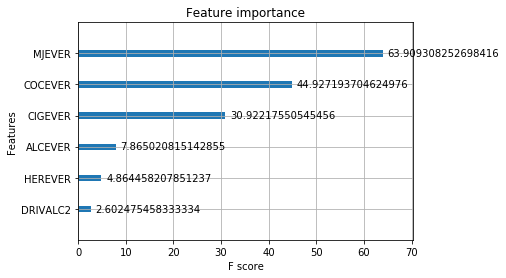

In [8]:
# plot_importance(model, importance_type='gain')
# pyplot.show()

In [34]:
Y_train = train[['BOOKED']]

Y_train[Y_train == 2] = 0
Y_train[Y_train == 4] = 0
Y_train[Y_train == 3] = 1
Y_train[Y_train == 85] = 0
Y_train[Y_train == 94] = 0
Y_train[Y_train == 97] = 1 #Refused to answer = yes
Y_train[Y_train == 98] = 1 #Left blank = yes

iterations = 500
sliceIndex = int(3000/iterations)
feats= []
threshold = int(len(X_train)*.3)
count = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

In [10]:
for i in range(1,iterations):
    X_train = train.iloc[:,list(range((i-1)*sliceIndex,i*sliceIndex))]
    model.fit(X_train, Y_train)
    rankings = model.booster().get_score(importance_type='gain')

    for key,value in rankings.items():
        if value > .8:
            counts = X_train[key].value_counts()
            try:
                condition1 = counts[99] < threshold
            except KeyError:
                try:
                    condition1 = counts[999] < threshold
                except KeyError:
                    try:
                        condition1 = counts[9999] < threshold
                    except:
                        condition1 = True
                        
            try:
                condition2 = counts[98] < threshold
            except KeyError:
                try:
                    condition2 = counts[998] < threshold
                except KeyError:
                    try:
                        condition2 = counts[9998] < threshold
                    except:
                        condition2 = True
                        
            if(condition1 and condition2):
                print(str(count) + key)
                feats.append([key, value])
        count = count + 1

1CIGEVER
2CASEID
3CIGTRY
5QUESTID2
8CIG30AV
9CIGREC
11CIG30USE
12CIG30TPE
13CIG30RO2
14CIGDLYMO
15CIG30MEN
16CIG30MLN
17CIG30BR2
20SNFEVER
21SNUFTRY
22CIG100LF
24SNUFMFU
25SNF30USE
26SNF30BR2
28SNUFYFU
29SNFREC
30CHEWREC
31CHEWEVER
32CHEWMFU
33CHEWTRY
34CHEWYFU
35CHW30USE
36SLTMFU
37CHW30BR2
38CH30EST
39SLTYFU
40SLTREC
41SLTTRY
42CIGARTRY
44SLT30BR2
46SLT30FAV
48PIPEVER
49CIGARREC
50CGR30BR2
51CI30EST
52PIPE30DY
53CGR30USE
54ALCREC
56ALCTRY
57ALCYRTOT
63ALBSTWAY
66MJEVER
68DR5DAY
69NODR30A
70ALCDAYS
71MJYRTOT
73MJREC
76MJAGE
77MRDAYPMO
79MJDAY30A
80MRDAYPYR
81MRDAYPWK
82MRBSTWAY
83COCAGE
84COCYFU
85COCEVER
86COCREC
87COCMFU
88MR30EST
89CCBSTWAY
91COCYRTOT
92CCDAYPMO
94CRKEVER
95CRKAGE
96CRKYFU
97CC30EST
98CCDAYPWK
99COCUS30A
101CRAKREC
102CRKYRTOT
105HEREVER
106CR30EST
109CRDAYPWK
110CRDAYPMO
111HERMFU
112HERAGE
114HERREC
115HERYRTOT
116HRBSTWAY
117HRDAYPMO
121HRDAYPWK
122PEYOTE
123MESC
124HR30EST
125PCP
126LSD
127PSILCY
128HALNEWB
130ECSTASY
131HALNEWC
132HALNOLST
133HALNEWA
134HALYFU

In [11]:
feats.sort(key=lambda x: x[1], reverse=True)

In [12]:
lst2 = [item[0] for item in feats]
lst2.remove('CASEID')
lst2.remove('QUESTID2')

In [28]:
lst2 = lst2[:50]

In [29]:
minXTrain = train[lst2]
minXTest = test[lst2]

In [30]:
Y_test = test[['BOOKED']]

Y_test[Y_test == 2] = 0
Y_test[Y_test == 4] = 0
Y_test[Y_test == 3] = 1
Y_test[Y_test == 85] = 0
Y_test[Y_test == 94] = 0
Y_test[Y_test == 97] = 1 #Refused to answer = yes
Y_test[Y_test == 98] = 1 #Left blank = yes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

In [31]:
model.fit(minXTrain, Y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [32]:
predictions = model.predict(minXTest)
roc_auc_score(Y_test, predictions)

0.85335990351064039

In [35]:
minXTrain.to_csv("X_Train.csv")
minXTest.to_csv("X_Test.csv")
Y_train.to_csv("Y_Train.csv")
Y_test.to_csv("Y_Test.csv")